### The Linear Regression File 

#### questions to answer:
##### do we need to use svm to 

In [63]:
### QUESTIONS FOR THE TA'S ###
# use the LEARNING CURVE to diagnose overfittng/underfitting (once you are done with this, go to the TA's and ask if this is a good methodology)
# 	- module05_02_cross_validation

# finish the part with the histagrams

# confidence interval for stack data???




import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [64]:
# test_list = ['first', 'second', 'third']
# final_dict = {}
# for i, element in enumerate(test_list):
# 	g = {'x' : i*i, 'y' : i+1}
# 	final_dict[element] = g
# print(final_dict)
# print(final_dict['second']['y'])
##############################################################################################################
arr = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
X = np.array([arr + (arr[-1]*i) for i in range(len(arr) - 2)])

def generate_y(array, horizon):
    close = array[:,4] ### 1)
    return close[horizon:] ### 2)


horizon = 7
G = X[:-horizon]
y = generate_y(X,horizon)

X_shape = X.shape
y_shape = y.shape

print(G.shape)
print(y_shape)


# # print(X)
# print(f'X.shape : {X.shape}')

# print('--'*25)

# horizon = 7
# G = X[:, :-horizon]
# # G = X
# J = G[:,4]

# print('--'*25)
# print(G)
# print(G.shape)
# print('--'*25)
# print(J)
# print(J.shape)
# print('--'*25)

# print('--'*25)

##############################################################################################################
# number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
#          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7

(3, 12)
(3,)


In [65]:
import preprocess
files = preprocess.potential_files[:5]

preprocess_class_instantiation = preprocess.preprocess(files, 7)

datasets = preprocess_class_instantiation.generate_data()

file_for_given_row = {}
for index, crypto_name in enumerate(files):
    file_for_given_row[crypto_name] = index
    # if crypto_name == '1INCH.csv':
    # print(f'index : {index} -- crypto_name : {crypto_name}')

# for key, val in file_for_given_row.items():
#     print(key, val)
    

# print(file_for_given_row['1INCH.csv'])

for f in files:
    print(f"https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select={f}")



# print(datasets)

processing files
Loading 1INCH.csv...
Loading AAVE.csv...
Loading ADA.csv...
Loading ALGO.csv...
Loading AMP.csv...
The columns are: (number of days since start,open,high,low,close,sma(10 days),golden cross, death cross)
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=1INCH.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=AAVE.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=ADA.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=ALGO.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=AMP.csv


In [66]:

for row, X_array in enumerate(datasets):
#     # 0 is X
#     # 1 is y
#     print(f'{X_array}')
    print(f'{datasets[row][0]} -- {X_array}')
# #     print(f'{datasets[row][0]} --')
# #     print('--'*50)

# for i in datasets:
    # print(i)
    

[[0 2.305 2.345 ... 2.2802857142857142 0 0]
 [1 2.224 2.41 ... 2.302571428571428 0 0]
 [2 2.343 2.436 ... 2.327285714285714 0 0]
 ...
 [1531 0.195878 0.197773 ... 0.19530242857142854 0 0]
 [1532 0.189552 0.190823 ... 0.19415528571428567 0 0]
 [1533 0.188428 0.203439 ... 0.1959125714285714 0 0]] -- (array([[0, 2.305, 2.345, ..., 2.2802857142857142, 0, 0],
       [1, 2.224, 2.41, ..., 2.302571428571428, 0, 0],
       [2, 2.343, 2.436, ..., 2.327285714285714, 0, 0],
       ...,
       [1531, 0.195878, 0.197773, ..., 0.19530242857142854, 0, 0],
       [1532, 0.189552, 0.190823, ..., 0.19415528571428567, 0, 0],
       [1533, 0.188428, 0.203439, ..., 0.1959125714285714, 0, 0]],
      dtype=object), array([2.792, 2.936, 2.809, ..., 0.179315, 0.177427, 0.181887],
      dtype=object))
[[0 448.49 485.36 ... 474.1985714285714 0 0]
 [1 481.02 482.68 ... 476.2614285714285 0 0]
 [2 453.37 469.78 ... 476.39571428571423 0 0]
 ...
 [1621 181.8827 190.5672 ... 182.80625714285713 0 0]
 [1622 180.7381 180

In [67]:
##### NESTED LIST RETRIEVAL OF X FOR GIVEN CURRENCY ##################################################################################
# filename = '1INCH.csv'

def get_X_or_y_for_given_currency(currency, x_or_y):
    processed_file_dict = {}

    if (x_or_y == 'X') or (x_or_y == 'x'):
        x_or_y = 0
    elif (x_or_y == 'Y') or (x_or_y == 'y'):
        x_or_y = 1
    else:
        print(f'x_or_y needs to be x or y')
    
    row = file_for_given_row[currency]
    
    for csv_name, row in file_for_given_row.items():
        if currency == csv_name:
            processed_file_dict[csv_name] = datasets[row][x_or_y]
            return processed_file_dict[csv_name]
    
# get_X_or_y_for_given_currency(filename, 'X')
# get_X_or_y_for_given_currency(filename, 'y')

In [68]:
currency_we_want_to_look_at = 'AAVE.csv'

X = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'X')
y = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'y')

print(X.shape)
print(y.shape)

# print("first row of X:", X[0])
# print("first 10 closes from X[:,4]:", X[:10, 4])
# print("first 10 y values:", y[:10])


(1624, 8)
(1624,)


# underfitted example of the first feature for a given dataset 

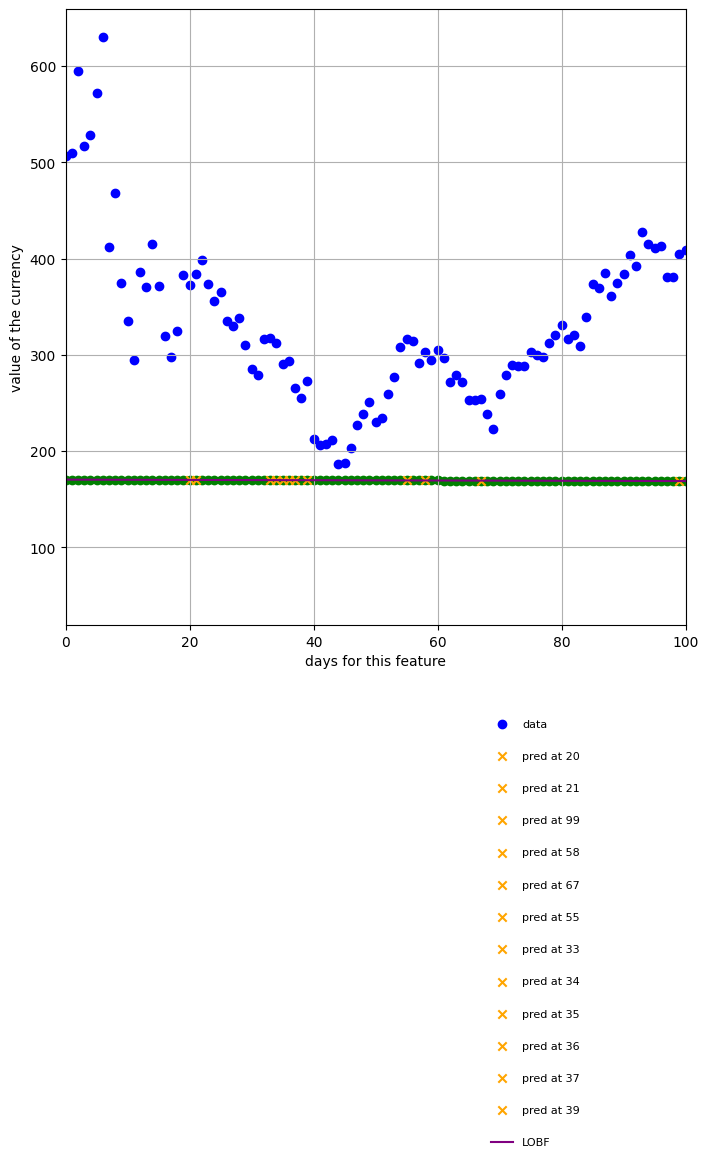

In [69]:

X0 = X[:, [0]] ## number of days since start
# X0 = X
pred_x_at_this_point = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]
### NOTE instantiate, fit, predict on X							#### MEMORIZE
lin_reg_model = LinearRegression()

lin_reg_model.fit(X0, y)
y_pred = lin_reg_model.predict(X0)


fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)

ax.scatter(X0, y, color='blue', alpha=1, label='data')

ax.scatter(X0,y_pred, color='green')

for i in pred_x_at_this_point:
	y_pred_new_x = lin_reg_model.predict(np.array([[i]]))#### MEMORIZE
	ax.scatter(i, y_pred_new_x, color='orange', marker='x', label=f'pred at {i}')

# for x_value, y_value in zip(X0[:, 0], y_pred):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(2,1), fontsize=8, color='green')
    
# for x_value, y_value in zip(X0[:, 0], y):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(1,1), fontsize=8, color='blue')
ax.set_xlim(0,100)
ax.plot(X0, y_pred, color='purple', label='LOBF')

# for i in range(len(X0)):
#     ax.arrow(X0[i, 0],y_pred[i],0,y[i]-y_pred[i], length_includes_head=True, color='red')

ax.set_xlabel('days for this feature')
ax.set_ylabel('value of the currency')
ax.legend(loc='center left', bbox_to_anchor=(0.5, -0.5), ncol=1, fontsize=8, frameon=False, borderaxespad=10, labelspacing=2)
ax.grid()
#################################################################################################################################

# Multivariable Linear Regression Section
### 1) find the most sig weihts (features) and dicuss what that means
### 2) get the LOBF to be fitted to the data trajectory
### 3) discuss various errors measured against the data and what that tells us about the real values vs our pred values ()

### find the magnitue and sign of coefficients

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### NOTE: instantiate Ridge class
lin_reg_model = Ridge()

### NOTE: fit the model (the obj) to the train of the lables and the dataset
lin_reg_model_train = lin_reg_model.fit(X_train, y_train)
### NOTE: make prediction lables for the train set
y_pred_train = lin_reg_model.predict(X_train)###########################################
### NOTE: make prediction lables for the test set
y_pred_test = lin_reg_model.predict(X_test)###########################################

### NOTE: get the MAE that measures the training lables against the predicted training labels
train_MAE = mean_absolute_error(y_train, y_pred_train)
### NOTE: get the MAE that measures the test lables against the predicted test labels
test_MAE = mean_absolute_error(y_test, y_pred_test)

train_MSE = mean_squared_error(y_train, y_pred_train)
test_MSE = mean_squared_error(y_test, y_pred_test)

train_RMSE = np.sqrt(train_MSE)
test_RMSE = np.sqrt(test_MSE)

naive_MAE = mean_absolute_error(y_test, np.full(y_test.shape, np.mean(y_train)))###########################################

print(f'train_MAE : {train_MAE}')
print(f'test_MAE : {test_MAE}')
print(f'train_MSE : {train_MSE}')
print(f'test_MSE : {test_MSE}')
print(f'train_RMAE : {train_RMSE}')
print(f'test_RMAE : {test_RMSE}')
print(naive_MAE)



train_MAE : 17.67953908748731
test_MAE : 18.42965065496553
train_MSE : 732.2949849379494
test_MSE : 841.5573619741658
train_RMAE : 27.060949446350723
test_RMAE : 29.009608097562534
81.0880429288848


In [71]:
y_pred_train_shape = y_pred_train.shape[0]
y_pred_test_shape = y_pred_test.shape[0]

print(y_pred_train_shape)
print(y_pred_test_shape)

x_axis_train = np.linspace(0, y_pred_train_shape, y_pred_train_shape)
x_axis_test = np.linspace(0, y_pred_test_shape, y_pred_test_shape)

print(x_axis_train.shape)
print(x_axis_test.shape)

1136
488
(1136,)
(488,)


In [72]:
w = lin_reg_model_train.coef_
b = lin_reg_model_train.intercept_

print(w)
# print(b)

# ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross

feature_names = ['number_of_days_since_start', 'open', 'high', 'low', 'close', 'sma(10_days)', 'golden_cross', 'death_cross']

max_coefficient = 0
most_influential_feature_name = 0
for feature_names, coefficients in zip(feature_names, w):
    if coefficients > max_coefficient:
        max_coefficient = coefficients
        most_influential_feature_name = feature_names
print(f'most_influential_feature_name : {most_influential_feature_name} -- max_coefficient : {max_coefficient}')

[ 2.67940332e-03  1.43521799e-01 -4.88520420e-01  2.10577945e-01
  7.73463497e-01  3.41051577e-01  1.26370025e+01  1.39593185e+01]
most_influential_feature_name : death_cross -- max_coefficient : 13.959318507320319


### get a function that fits the line better 

##### A model that is overfitting has the following characteristics:

###### - It matches the training set too closely.
###### - It does well on the training data, but doesn't *generalize* to new data.  In other words, it performs poorly on independent test data.
###### - It learns from the noise in the data, rather than the signal.

In [73]:
# feature_indecies = [1,2,3,4,5,6,7]
feature_indecies = np.array([[30,22,123,222,333,12112,444],[1,2,3,4,5,6,7]])
# print(X[:, feature_indecies].shape)
# print(X[:len(y), feature_indecies].shape)
# print(y.shape)
print(X0[22,0])

print(X[22, 0])
# print(feature_indecies)
# print(feature_indecies.shape)
# print()
# feature_indecies = feature_indecies.reshape(1, -1)
# print(feature_indecies)
# print(feature_indecies.shape)


22
22


In [74]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# X0 = X[:, [0]]

# polynomial_degrees = [1,2,3,4,5,6,7]
# feature_indecies = [1,2,3,4,5,6,7]
# pred_x_at_this_point = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]

# plt.figure(figsize=(20,10))
# for i in range(len(polynomial_degrees)):
#     ax = plt.subplot(1, len(polynomial_degrees), i + 1)
    
#     ### NOTE: make the line eq a mutlti-var lin eq
#     polynomial_features = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
    
#     ### NOTE: apply lin reg to the new mutlti-var lin eq
#     linear_regression_model = LinearRegression()
    
#     ### NOTE: instantiate the pipline
#     pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression_model)])
    
#     ### NOTE: apply the pipline
#     pipeline.fit(X[:, feature_indecies], y)
    
#     for h in pred_x_at_this_point:
#         y_pred_at_this_point = pipeline.predict(np.array([[h]+[0]*6]))[0]##now a 2d array with 7 features
#         ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f"pred at {h}")
        
    
    
#     plt.xlabel('x')
#     plt.ylabel('y')
#     ax.scatter(X0, y, color="blue")
#     ax.scatter(X_train, y_train, color="green", label='trian')
#     ax.scatter(X_train, y_train, color="red", label='test')
#     ax.set_xlim(0,100)
#     ax.set_ylim(-1000,1000)
    
#     ax.plot(X0, pipeline.predict(X[:, feature_indecies]), label="model", color="purple")
    
#     ax.set_xlabel('days for this feature')
#     ax.set_ylabel('value of the currency')
#     plt.title(f"Degree {polynomial_degrees[i]}")
#     ax.legend()
#     ax.grid() 
    
# # ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
# # ##          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7

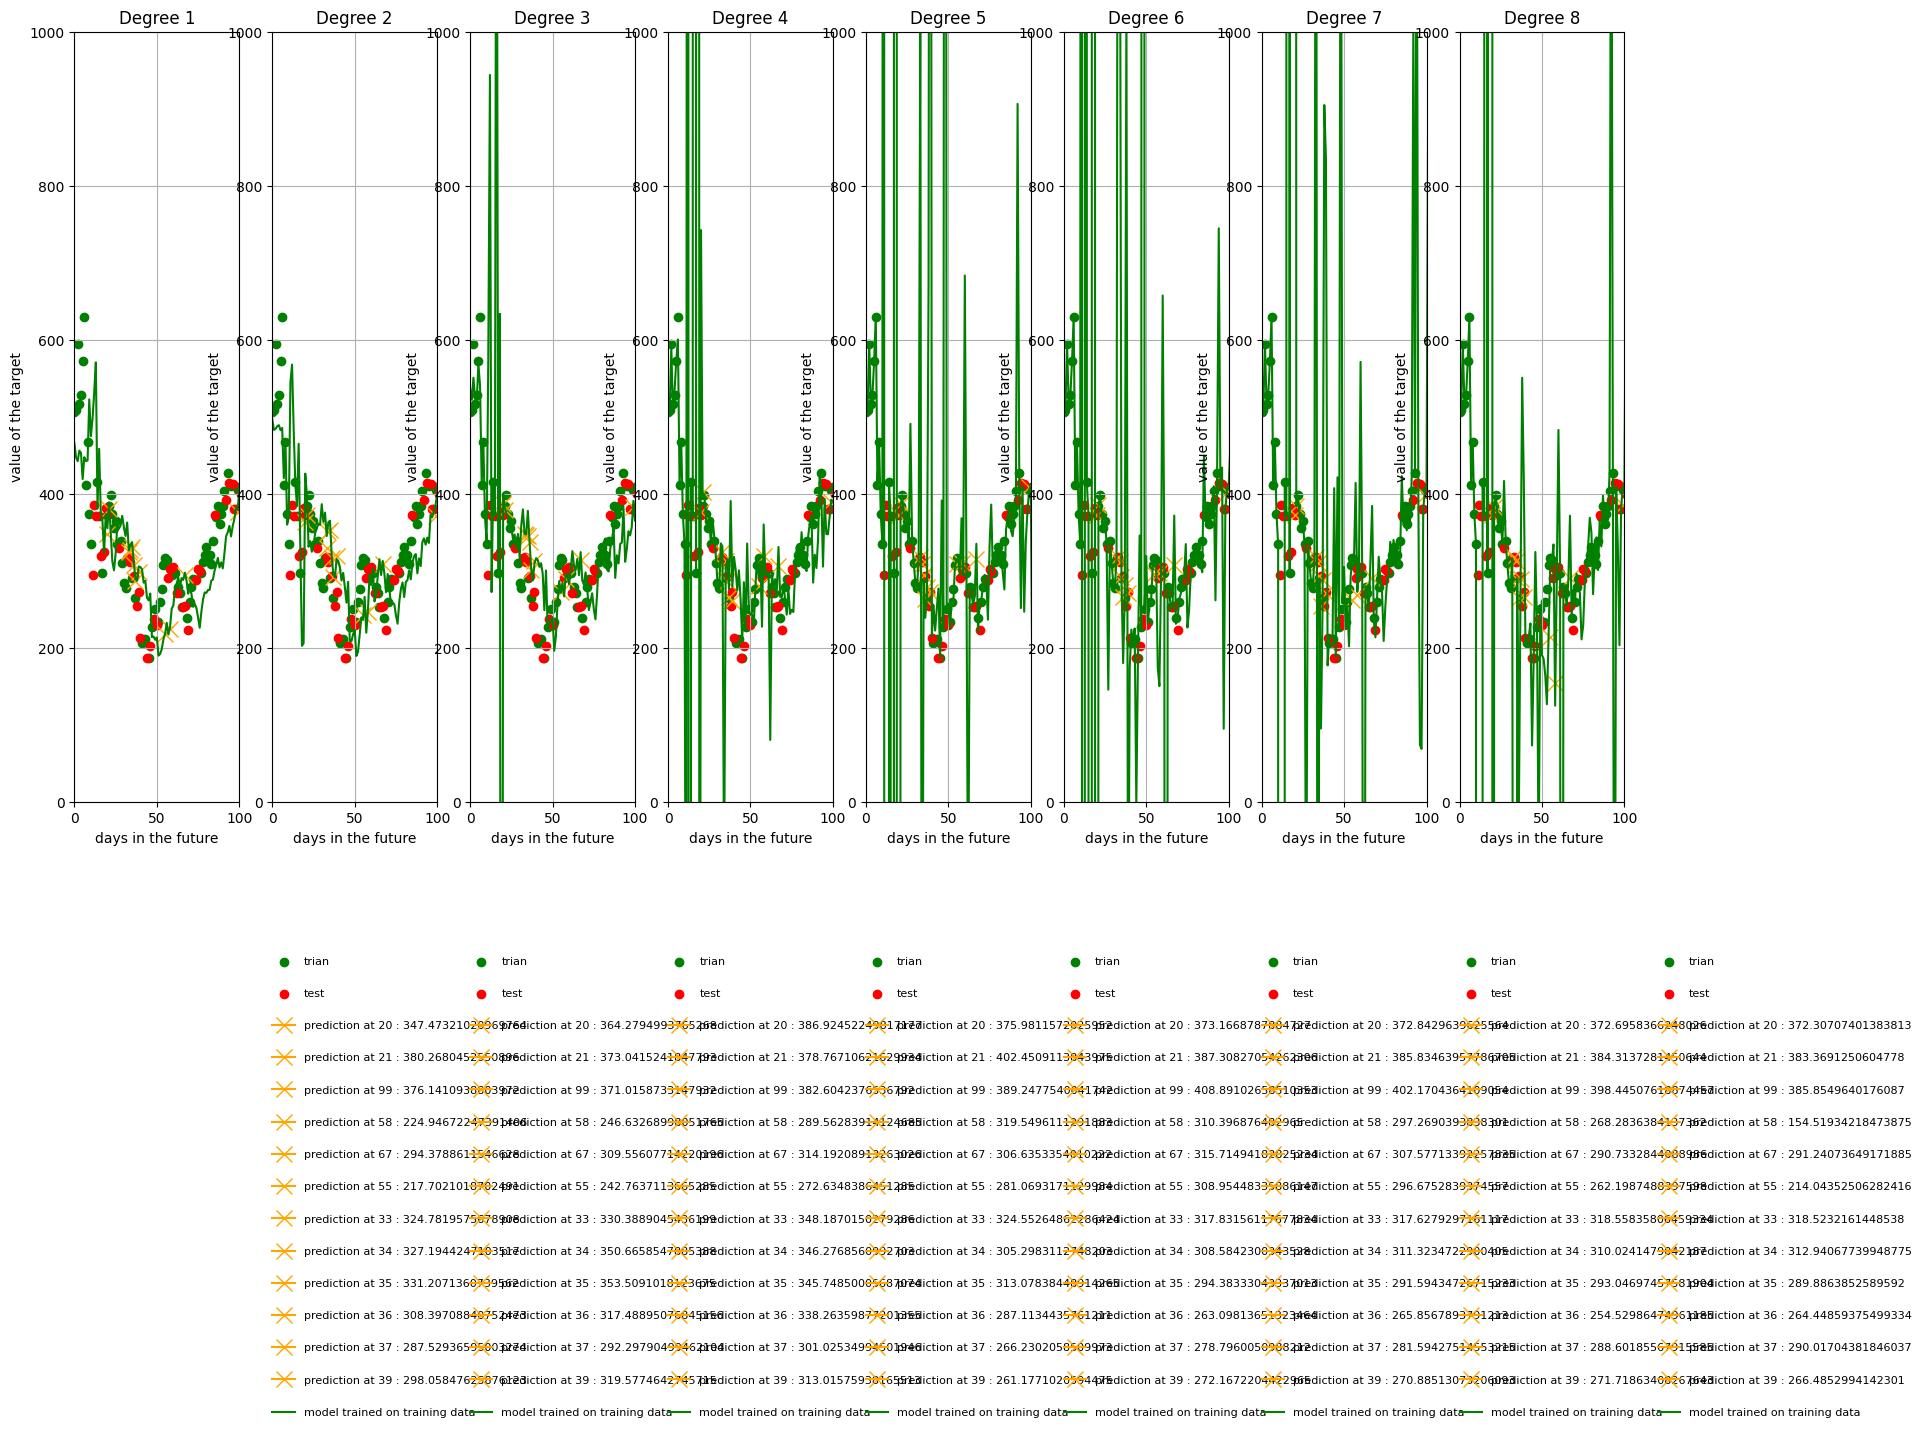

In [75]:
# # ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
# # ##          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

polynomial_degrees = [1,2,3,4,5,6,7,8]
feature_indecies = [0,1,2,3,4,5,6,7]
pred_x_at_this_point = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]

def get_prediction_at_given_x(pipeln):
    for h in pred_x_at_this_point:
        x_row = X[h, feature_indecies].reshape(1, -1)
        y_pred_at_this_point = pipeln.predict(x_row)[0]
        # print(y_pred_at_this_point)
        # print(X[h,0])
        # print(h)
        ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f'prediction at {h} : {y_pred_at_this_point}', markersize=12)
    
    

train_and_test_errors_at_given_degree = {}

plt.figure(figsize=(20,10))
for i in range(len(polynomial_degrees)):
    # print(X[:, feature_indecies].shape)
    # print(y.shape)
    
    ax = plt.subplot(1, len(polynomial_degrees), i + 1)
    ax = plt.subplot(1, len(polynomial_degrees), i + 1)
    
    ### NOTE: make the line eq a mutlti-var lin eq
    polynomial_features1 = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
    polynomial_features_train = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
    
    ### NOTE: apply lin reg to the new mutlti-var lin eq
    linear_regression_model1 = LinearRegression()
    linear_regression_model_train = LinearRegression()
    
    ### NOTE: instantiate the pipline
    pipeline1 = Pipeline([("polynomial_features", polynomial_features1), ("linear_regression", linear_regression_model1)])
    pipeline_on_training_data = Pipeline([("polynomial_features", polynomial_features_train), ("linear_regression", linear_regression_model_train)])
    
    ### NOTE: apply the pipline
    pipeline1.fit(X[:, feature_indecies], y)
    
    ##spilt 
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X[:, feature_indecies], y, test_size=0.3, random_state=67)

    ##fit 
    pipeline_on_training_data.fit(X_train2, y_train2)
    
    ##predict on train and test
    y_pred_train2 = pipeline_on_training_data.predict(X_train2)
    y_pred_test2 = pipeline_on_training_data.predict(X_test2)
    
    train_MAE2 = mean_absolute_error(y_train2, y_pred_train2)
    test_MAE2 = mean_absolute_error(y_test2, y_pred_test2)
    
    train_MSE2 = mean_squared_error(y_train2, y_pred_train2)
    test_MSE2 = mean_squared_error(y_test2, y_pred_test2)

    train_RMSE2 = np.sqrt(train_MSE2)
    test_RMSE2 = np.sqrt(test_MSE2)
    
    naive_MAE2 = mean_absolute_error(y_test2, np.full(y_test2.shape, np.mean(y_train2)))
    
    # for h in pred_x_at_this_point:
    #     y_pred_at_this_point = pipeline_on_training_data.predict(np.array([[h]+[0]*6]))[0]
    #     ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f"pred at {h}")
        
    plt.xlabel('x')
    plt.ylabel('y')
    # ax.scatter(X0, y, color="blue")
    ax.scatter(X_train2[:,0], y_train2, color="green", label='trian')
    ax.scatter(X_test2[:,0], y_test2, color="red", label='test')
    ax.set_xlim(0,100)
    ax.set_ylim(0,1000)
    
    LOBF_X = pipeline1.predict(X[:, feature_indecies])
    LOBF_train_set = pipeline_on_training_data.predict(X[:, feature_indecies])
    # LOBF_train_set = pipeline_on_training_data.predict(X_test2[:, feature_indecies])###### ask about this!!!!!!!
    
    get_prediction_at_given_x(pipeline1)
    
    # ax.plot(X0, LOBF_X, label="model trained on all data", color="purple", linewidth=2) data leakage 
    ax.plot(X0, LOBF_train_set, label="model trained on training data", color="green")
    
    ax.set_xlabel(f'days in the future')
    
    ax.set_ylabel('value of the target')
    ax.legend(loc='center left', bbox_to_anchor=(0.5, -0.5), ncol=1, fontsize=8, frameon=False, borderaxespad=10, labelspacing=2)
    plt.title(f"Degree {polynomial_degrees[i]}")
    ax.grid()   
    
    train_and_test_errors_at_given_degree[i] = {
        
        'train' : {
            'MAE' : train_MAE2,
            'MSE' : train_MSE2,
            'RMSE' : train_RMSE2
        },
        'test' : {
            'MAE' : test_MAE2,
            'MSE' : test_MSE2,
            'RMSE' : test_RMSE2
        },
        'naive_MAE' : naive_MAE2
    }
        

In [ ]:
# for i in range(len(polynomial_degrees)):
    
#     print(f"degree {i} train MAE : {train_and_test_errors_at_given_degree[i]['train']['MAE']}")
#     print(f"degree {i} test MAE : {train_and_test_errors_at_given_degree[i]['test']['MAE']}")
    
#     print(f"degree {i} train MSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
#     print(f"degree {i} test MSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
    
#     print(f"degree {i} train RMSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
#     print(f"degree {i} test RMSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
#     print(f"degree {i} test RMSE : {train_and_test_errors_at_given_degree[i]['naive_MAE']}")

### show MAE, MSE, and RMSE and explain what this means for the predictions of the selected feature

#### * high train error, high test error --> underfitting
#### * low train error, high test error --> overfitting
#### * low train error, low test error --> well fitted

*RMSE*: 
- it penalizes the large errors more, it highlights models with fewer big mistakes
- we square all the errors to make them non-negative and to penalize larger mistakes disproprtionately 
	- big misses weigh more than small ones 	

*MSE*: 

# Selecting the best degree by lowest RMSE (if there is a tie between one or more rows then we will switch to the MAE)

### the order of selection in the tie-break selection process is RMSE, MAE 
### - RMSE to punish outliers (aka bigger mistakes/larger residuals)
### - MAE as a secondary because absolute error is usful for punishing more smaller residulas and less sensitive to outliers

   deg  train_RMSE      test_RMSE  train_MAE     test_MAE   naiveMAE
0    1   27.067344      29.219372  17.577409    18.273394  78.947806
1    2   24.600045      31.733301  16.426798    19.090914  78.947806
2    3   21.784361     118.583877  14.768766    26.499701  78.947806
3    4   18.728269    2020.024354  12.666498   175.876670  78.947806
7    8   19.358402   25439.202574  12.499714  2658.135005  78.947806
4    5   15.033738   39644.923298  10.201290  2965.945476  78.947806
6    7   14.027410   59483.984029   9.688057  4574.120895  78.947806
5    6   12.923444  129525.060373   8.803521  8533.969885  78.947806
deg            1.000000
train_RMSE    27.067344
test_RMSE     29.219372
train_MAE     17.577409
test_MAE      18.273394
naiveMAE      78.947806
Name: 0, dtype: float64
1


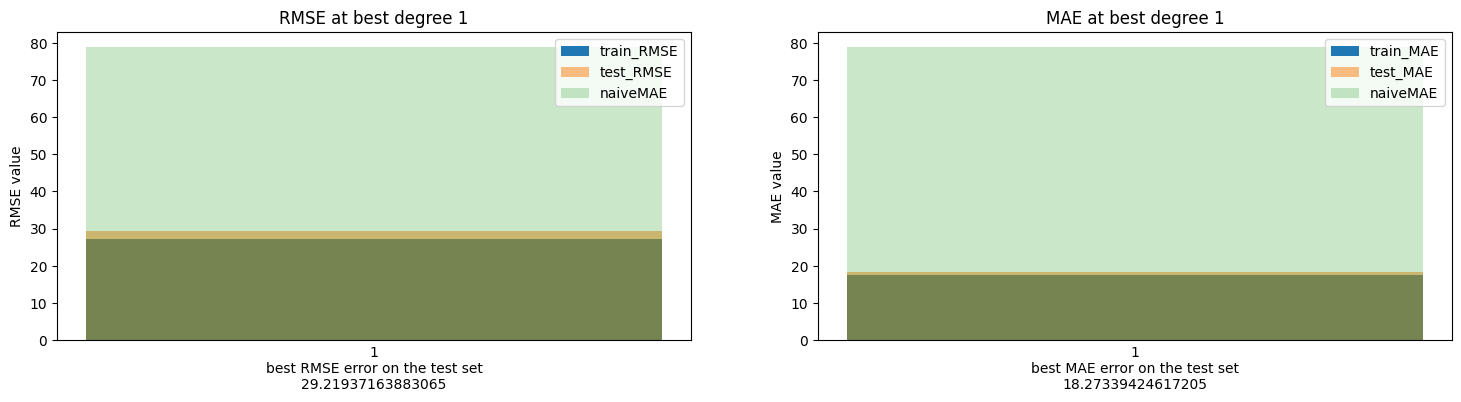

In [102]:
# https://www.youtube.com/watch?v=G0Olm-4CP50
# build a data frame of the collected errors 
rows = []
for i, deg in enumerate(polynomial_degrees):
    m = train_and_test_errors_at_given_degree[i]
    rows.append({
		'deg' : deg,
		'train_RMSE' : m['train']['RMSE'],
  		'test_RMSE' : m['test']['RMSE'],
    	'train_MAE' : m['train']['MAE'],
		'test_MAE' : m['test']['MAE'],
		'naiveMAE' : m['naive_MAE']

	})
# make a dataframe of the rows list using .sort_values by degree
metrics_df = pd.DataFrame(rows).sort_values(['test_RMSE', 'test_MAE'], ascending=True)
print(metrics_df)
# pick best degree (row) by the lowest test RMSE key then test MAE key then initialize the 
best_row = metrics_df.sort_values(['test_RMSE', 'test_MAE'], ascending=True).iloc[0]
print(best_row)
best_degree = int(best_row['deg'])
print(best_degree)

# plot bar charts t ocompare errors accross degrees 
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
	# - axs 0, 1, and 2 is the bar of the degree key for x and te train/test_error key for y, make sure to use aplpha to make it more transparent
# axs[0].bar(metrics_df['deg'], metrics_df['train_RMSE'], label='train_RMSE', alpha=1)
# axs[0].bar(metrics_df['deg'], metrics_df['test_RMSE'], label='test_RMSE', alpha=0.5)
# axs[0].set_title('RMSE for each degree')
# axs[0].set_xlabel('degree')
# axs[0].set_ylabel('RMSE')
# axs[0].legend()

# axs[1].bar(metrics_df['deg'], metrics_df['train_MAE'], label='train_MAE', alpha=1)
# axs[1].bar(metrics_df['deg'], metrics_df['test_MAE'], label='test_MAE', alpha=0.5)
# axs[1].set_title('MAE for each degree')
# axs[1].set_xlabel('degree')
# axs[1].set_ylabel('MAE')
# axs[1].legend()


axs[0].bar(best_row['deg'], best_row['train_RMSE'], label='train_RMSE', alpha=1)
axs[0].bar(best_row['deg'], best_row['test_RMSE'], label='test_RMSE', alpha=0.5)
axs[0].bar(best_row['deg'], best_row['naiveMAE'], label='naiveMAE', alpha=0.25)
axs[0].set_title(f'RMSE at best degree {best_degree}')
axs[0].set_xlabel(f"{best_degree}\nbest RMSE error on the test set\n{best_row['test_RMSE']}")
axs[0].set_xticks([])
axs[0].set_ylabel('RMSE value')
axs[0].legend()

axs[1].bar(best_row['deg'], best_row['train_MAE'], label='train_MAE', alpha=1)
axs[1].bar(best_row['deg'], best_row['test_MAE'], label='test_MAE', alpha=0.5)
axs[1].bar(best_row['deg'], best_row['naiveMAE'], label='naiveMAE', alpha=0.25)
axs[1].set_title(f'MAE at best degree {best_degree}')
axs[1].set_xlabel(f"{best_degree}\nbest MAE error on the test set\n{best_row['test_MAE']}")
axs[1].set_xticks([])
axs[1].set_ylabel('MAE value')
axs[1].legend()


## I am going to ask a TA about how to get the graph of the best degree here alonside with the prediction value that can be returned to the front end and have that prediction value plotted as a point on the graph

In [ ]:
# for i in range(len(polynomial_degrees)):
    # if i == best_degree:
        

# FINAL THINGS THAT NEED TO BE PUSHED TO THE FRONT END
## 1) the best fit graph
## 2) the 'RMSE at best degree' and 'MAE at best degree' bar charts
## 3) the predicted value (accompanied by the name of the currency preferably)